In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.sparse import diags
np.set_printoptions(precision=2)
from simple_plot import *

# Ch. 9 - Time and Space Stepping Schemes: The Method of Lines

Here we introduce methods for partial differential equations (PDEs) whose independent variables include both spatial coordinate(s) and time. The approach considered is:

- Discretize both space and time: $$x_i = i \Delta x \; ; \; t_k = k \Delta t$$

- Apply initial conditions at initial time: $$u(x,0) = U_0(x)$$

- Estimate derivatives using finite differences.

- Step forward to compute values for $u(x_i, t_1)$

- Repeat to compute values for $u(x_i, t_k)$

To be concrete, let's consider the __heat equation__ (the example parabolic 2nd order linear PDE):

$$ \frac{\partial u}{\partial t} = \kappa \frac{\partial^2 u}{\partial x^2} \text{ or } u_t = \kappa u_{xx}$$

and start with the simplest approach:

- Centered difference for spatial derivative:

$$\frac{\partial^2 u}{\partial x^2}=\frac{1}{\Delta x^2}(u_{i-1}-2 u_i + u_{i+1})$$

- Forward difference for time derivative:

$$ \implies \frac{\partial u}{\partial t} = \frac{1}{\Delta t} (u_{k+1}-u_k)$$

- Put the pieces together and tracking both index values ($i$ for space and $k$ for time), we get a difference equation for stepping forward in time:

$$u_{i,k+1}= u_{i,k}+\frac{\Delta t}{\Delta x^2}(u_{i-1,k}-2 u_{i,k} + u_{i+1,k})$$

which translates into python as:

```
u[i,k+1] = u[i,k]+ dt/dx**2*(u[i-1,k]-2*u[i,k]+u[i,k+1])
```


Let's create a vector $\boldsymbol{u}$ to hold the values on the discrete spatial grid over 20 timesteps. We'll fill the first row with the initial conditions and apply the stepping method to fill in the remaining values (while maintaining the homogeneous Dirichlet boundary conditions along the edges):

In [17]:
def forward_euler_heatstep(u0, dx, dt):
    '''
    compute the array produced by a forward euler step
    
    Args:
        u0: 1D numpy array of current values
        dx: float spacing between nodes on the spatial grid
        dt: float time step
        
    Returns:
        v: 1D numpy array of updated values
    '''
    v = np.copy(u0)
    n = v.shape[0]
    lam = dt/(dx**2)
    for i in range(1,n-1):
        v[i]+=lam*(u0[i-1]-2*u0[i]+u0[i+1])
    return v

In [18]:
# equivalent "direct solve" version array to represent the discretized spatial derivative
def forward_euler_matrix_heatstep(u0, dx, dt):
    '''
    compute the array produced by a forward euler step
    
    Args:
        u0: 1D numpy array of current values
        dx: float spacing between nodes on the spatial grid
        dt: float time step
        
    Returns:
        v: 1D numpy array of updated values
    '''
    v = np.copy(u0)
    n = u0.shape[0]
    lam = dt/(dx**2)
    A = diags([1,-2,1],[-1,0,1], shape=[n,n])
    v += lam*A.dot(u0)
    v[0],v[-1] = 0, 0 # impose boundary conditions
    return v

In [19]:
def forward_euler_heatsolve(x, t, ICs):
    '''
    compute solution of heat equation by forward euler/central diff.
    
    Args:
        x: 1D numpy array of uniformly spaced grid coordinates corr. to linspace(xmin, xmax, nx+1)
        t: 1D numpy array of uniformly spaced time values corr. to linspace(tmin, tmax, nt+1)
        ICs: 1D numpy array of initial values
        
    Returns:
        u: 2D numpy array of solution values
    '''
    nx = x.shape[0]
    if nx != ICs.shape[0]:
        print("Length of initial condition array does not match spatial gridsize.")
        return
    nt = t.shape[0]
    dx = (x[-1]-x[0])/(nx-1)
    dt = (t[-1]-t[0])/(nt-1)
    u = np.zeros([nt,nx])
    u[0] = ICs
    for k in range(1,nt):
        #swithc comment status of the next 2 lines to use the matrix implementation
        u[k] = forward_euler_heatstep(u[k-1], dx, dt)
        #u[k] = forward_euler_matrix_heatstep(u[k-1], dx, dt)
    return u       

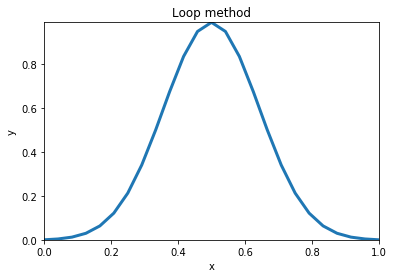

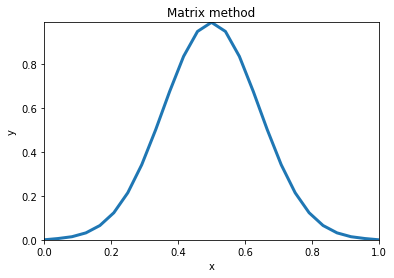

In [46]:
xmin, xmax, nx = 0, 1, 25
x = np.linspace(xmin, xmax,nx) #compute the coordinates of the grid points
dx = (xmax-xmin)/(nx-1) #spacing between grid points
tmin, tmax, nt = 0, 0.02, 100
t = np.linspace(tmin, tmax, nt)
dt = (tmax-tmin)/(nt-1) #time step
u = np.zeros([nt,nx]) #initialize array of zeros to store u(x,t)
ICs = np.exp(-((x-0.5)/0.2)**2) #Gaussian initial conditions
u[0] = ICs

#check that loop and array implementations agree
u = forward_euler_heatstep(ICs, dx, dt)
arrayplot(x,u.T,titlestring="Loop method")
v = forward_euler_matrix_heatstep(ICs, dx, dt)
arrayplot(x,v.T,titlestring="Matrix method")

For true verification, plot the difference:

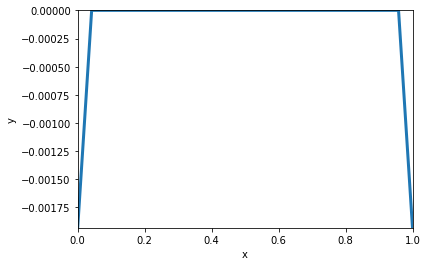

In [47]:
arrayplot(x,v.T-u.T)

Why is there a difference at the edges? The initial condition specified does not quite satisfy the boundary conditions, and we did not "manually" impose the boundary conditions in the loop implementation. (You are welcome to fix that oversight...)

Now let's call the solver to generate a 2D array of temperature on the grid of locations and times.

In [66]:
#repeat of initialization
xmin, xmax, nx = 0, 1, 25
x = np.linspace(xmin, xmax,nx) #compute the coordinates of the grid points
dx = (xmax-xmin)/(nx-1) #spacing between grid points
tmin, tmax, nt = 0, 0.05, 75
t = np.linspace(tmin, tmax, nt)
dt = (tmax-tmin)/(nt-1) #time step
u = np.zeros([nt,nx]) #initialize array of zeros to store u(x,t)
ICs = np.exp(-((x-0.5)/0.2)**2) #Gaussian initial conditions
u[0] = ICs

In [67]:
sol = forward_euler_heatsolve(x, t, ICs)

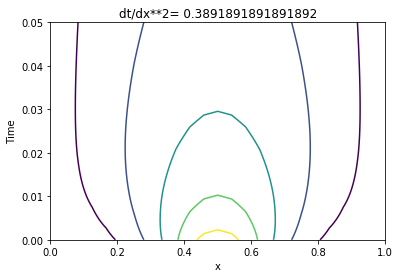

In [68]:
arraycontourplot(t, x, sol, labels=['x','Time'], titlestring="dt/dx**2= "+str(dt/dx**2), levels=[0.1, 0.3,0.5, 0.7,0.9])

This looks reasonable. For larger values of t:

- High temperature isotherms terminate.

- Remaining isotherms become further apart (indicating declining gradient magnitude expected of diffusive process)

This may be a bit easier to interpret if we plot the data as a wire-frame mesh:

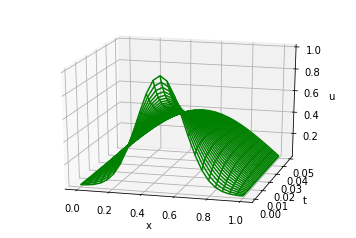

In [73]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection="3d")

X, Y = np.meshgrid(x, t)
Z = sol #z_function(X, Y)

ax.plot_wireframe(X, Y, Z, color='green')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.view_init(20, -75) #elevation and azimuth (rotation around z-axis) for viewing
plt.show()



Or as a shaded surface:

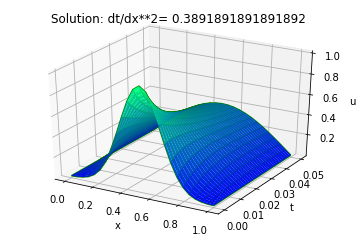

In [74]:
fig = plt.figure()
ax = plt.axes(projection="3d")

X, Y = np.meshgrid(x, t)
Z = sol #z_function(X, Y)

ax.plot_wireframe(X, Y, Z, color='green')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_title('Solution: dt/dx**2= '+str(dt/dx**2))

plt.show()

So we have a reasonable looking solution: the heat diffuses so the highest temperature contours die out, and the spacing between temperature levels increases (associated with reduced gradient magnitude).

What happens if we change the time step? Can we get away with fewer time steps?

In [75]:
#repeat of initialization
xmin, xmax, nx = 0, 1, 25
x = np.linspace(xmin, xmax,nx) #compute the coordinates of the grid points
dx = (xmax-xmin)/(nx-1) #spacing between grid points
tmin, tmax, nt = 0, 0.05, 50
t = np.linspace(tmin, tmax, nt)
dt = (tmax-tmin)/(nt-1) #time step
u = np.zeros([nt,nx]) #initialize array of zeros to store u(x,t)
ICs = np.exp(-((x-0.5)/0.2)**2) #Gaussian initial conditions
u[0] = ICs

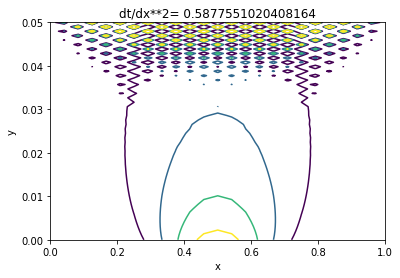

In [76]:
sol = forward_euler_heatsolve(x, t, ICs)
arraycontourplot(t, x, sol, titlestring="dt/dx**2= "+str(dt/dx**2), levels=[0.3,0.5, 0.7,0.9])

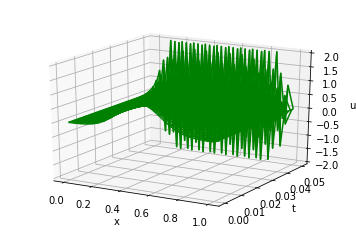

In [87]:
fig = plt.figure()
ax = plt.axes(projection="3d")

X, Y = np.meshgrid(x, t)
Z = np.clip(sol,-2,2)

ax.plot_wireframe(X, Y, Z, color='green')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.view_init(20,-60) #elevation and azimuth (rotation around z-axis) for viewing
plt.show()

Or as a shaded surface:

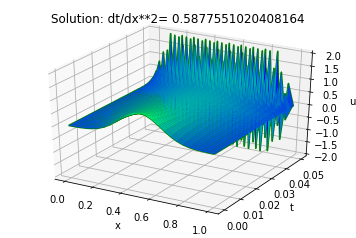

In [89]:
fig = plt.figure()
ax = plt.axes(projection="3d")

X, Y = np.meshgrid(x, t)
Z = Z = np.clip(sol,-2,2) 

ax.plot_wireframe(X, Y, Z, color='green')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_title("Solution: dt/dx**2= "+str(dt/dx**2));

plt.show()

It looks similar at the start and then it turns into something resembling noise.

This is __instability__ arising, and we should take it as a warning to be careful about choosing the stepsizes when we discretize. In this case, we see very different behavior for $\Delta t /\Delta x^2 \approx 0.4$ and $\Delta t /\Delta x^2 \approx 0.6$.

You will take a closer look at this equation in your homework. Here we go on to look at a version of the next "canonical" equation.

# Section 9.2 - Time-Stepping Schemes: Explicit and Implicit Methods

Now we move on to an equation with wave propoagation, and we will folow the text and look at the __"one-way wave equation"__:

$$\frac{\partial u}{\partial t} = c \frac{\partial u}{\partial x}$$

Recall that we could look for characteristic solutions of the form $u(x,t) = f(x+kt)$

Again we start simple with the first central difference in x and first forward difference in t:

`u[i,k+1] = u[i,k]+lam/2*(u[i+1,k]-u[i-1,k])` where `lam = c*dt/dx`.

Let's code this up (by modifying what we did for the heat equation):

In [92]:
def forward_euler_wave1way_step(u0, dx, dt, c):
    '''
    compute the array produced by a forward euler step from u
    '''
    v = np.copy(u0)
    n = v.shape[0]
    lam = c*dt/(2*dx)
    for i in range(1,n-1):
        v[i]+=lam*(-u0[i-1] + u0[i+1])
    return v

def forward_euler_wave1way_solve(x, t, ICs, c):
    '''
    compute solution of heat equation by forward euler/central diff.
    '''
    nx = x.shape[0]
    nt = t.shape[0]
    dx = (x[-1]-x[0])/(nx-1)
    dt = (t[-1]-t[0])/(nt-1)
    u = np.zeros([nt,nx])
    u[0] = ICs
    for k in range(1,nt):
        u[k] = forward_euler_wave1way_step(u[k-1], dx, dt, c)
    return u  

In [121]:
#initialization including wave speed
c = 1.
xmin, xmax, nx = -1, 1, 25
x = np.linspace(xmin, xmax,nx) #compute the coordinates of the grid points
dx = (xmax-xmin)/(nx-1) #spacing between grid points
tmin, tmax, nt = 0, 0.4, 100
t = np.linspace(tmin, tmax, nt)
dt = (tmax-tmin)/(nt-1) #time step
u = np.zeros([nt,nx]) #initialize array of zeros to store u(x,t)
ICs = np.exp(-((x-0.5)/0.2)**2) #Gaussian initial conditions
u[0] = ICs

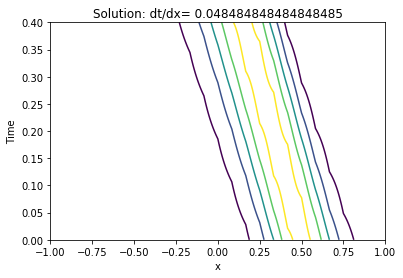

In [122]:
sol = forward_euler_wave1way_solve(x, t, ICs, c)
arraycontourplot(t, x, sol, labels=['x','Time'], levels=[0.1,0.3,0.5, 0.7,0.9], titlestring="Solution: dt/dx= "+str(dt/dx))

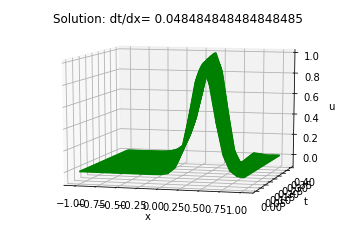

In [128]:
fig = plt.figure()
ax = plt.axes(projection="3d")

X, Y = np.meshgrid(x, t)
Z = np.clip(sol,-2,2)

ax.plot_wireframe(X, Y, Z, color='green')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.view_init(10,-75) #elevation and azimuth (rotation around z-axis) for viewing
ax.set_title("Solution: dt/dx= "+str(dt/dx))
plt.show()

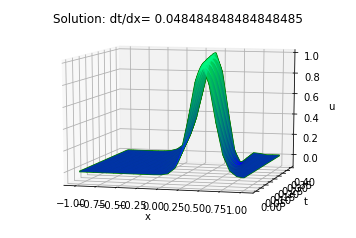

In [127]:
fig = plt.figure()
ax = plt.axes(projection="3d")

X, Y = np.meshgrid(x, t)
Z = Z = np.clip(sol,-2,2) 

ax.plot_wireframe(X, Y, Z, color='green')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_title("Solution: dt/dx= "+str(dt/dx));
ax.view_init(10,-75) #elevation and azimuth (rotation around z-axis) for viewing
plt.show()

Again things look reasonable (with values propagating nicely along characteristic lines).

But what happens when we continue over a longer time interval?

In [152]:
#initialization including wave speed
c = 1.
xmin, xmax, nx = -1, 1, 25
x = np.linspace(xmin, xmax,nx) #compute the coordinates of the grid points
dx = (xmax-xmin)/(nx-1) #spacing between grid points
tmin, tmax, nt = 0, 1.0, 100
t = np.linspace(tmin, tmax, nt)
dt = (tmax-tmin)/(nt-1) #time step
u = np.zeros([nt,nx]) #initialize array of zeros to store u(x,t)
ICs = np.exp(-((x-0.5)/0.2)**2) #Gaussian initial conditions
u[0] = ICs

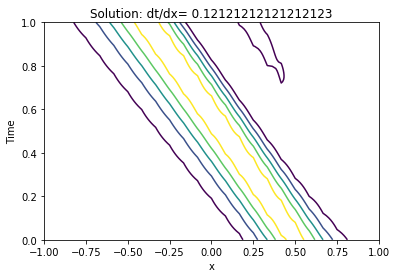

In [153]:
sol = forward_euler_wave1way_solve(x, t, ICs, c)
arraycontourplot(t, x, sol, labels=['x','Time'], levels=[0.1,0.3,0.5, 0.7,0.9], titlestring="Solution: dt/dx= "+str(dt/dx))

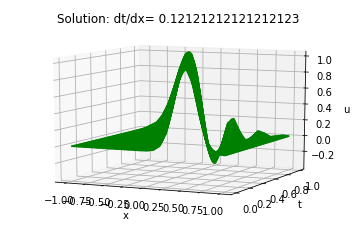

In [137]:
fig = plt.figure()
ax = plt.axes(projection="3d")

X, Y = np.meshgrid(x, t)
Z = np.clip(sol,-2,2)

ax.plot_wireframe(X, Y, Z, color='green')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.view_init(10,-65) #elevation and azimuth (rotation around z-axis) for viewing
ax.set_title("Solution: dt/dx= "+str(dt/dx))
plt.show()

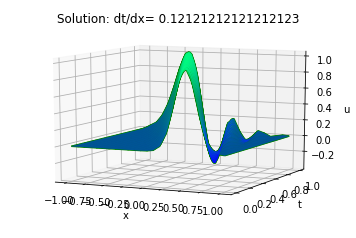

In [136]:
fig = plt.figure()
ax = plt.axes(projection="3d")

X, Y = np.meshgrid(x, t)
Z = Z = np.clip(sol,-2,2) 

ax.plot_wireframe(X, Y, Z, color='green')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_title("Solution: dt/dx= "+str(dt/dx));
ax.view_init(10,-65) #elevation and azimuth (rotation around z-axis) for viewing
plt.show()

Once again, errors creep in and instability arises suggesting that the time step is too large.

Can we avoid this difficulty by using a more accurate (higher order) difference scheme to approximate the derivatives?

Let's start with a more accurate estimate of the time derivative. (Note that the forward difference in the Euler method has truncation error $\approx O(\Delta t)$ and centered difference has truncation error  $\approx O(\Delta t^2)$.

__Central Differencing in Time: Leap-Frog Scheme__ 

(Note that this will require one Euler step to get started.)

`u[i,k+1] = u[i,k-1] + lam*(u[i+1,k]-u[i-1,k])` where `lam = c*(2*dt)/(2*dx)`

Let's code it up and see what happens:

In [154]:
def leapfrog_wave1way_step(u0, u1, dx, dt, c):
    '''
    compute the array produced by a forward euler step from u
    '''
    v = np.copy(u0)
    n = v.shape[0]
    lam = c*dt/dx
    v[0], v[-1]= 0,0 #apply boundary conditions
    for i in range(1,n-1):
        v[i]= u0[i]+lam*(-u1[i-1] + u1[i+1])
    return v

def leapfrog_wave1way_solve(x, t, ICs, c):
    '''
    compute solution of heat equation by forward euler/central diff.
    '''
    nx = x.shape[0]
    nt = t.shape[0]
    dx = (x[-1]-x[0])/(nx-1)
    dt = (t[-1]-t[0])/(nt-1)
    u = np.zeros([nt,nx])
    u[0] = ICs
    u[1] = forward_euler_wave1way_step(u[0], dx, dt, c)
    for k in range(2,nt):
        u[k] = leapfrog_wave1way_step(u[k-2],u[k-1], dx, dt, c)
    return u  

In [194]:
#initialization including wave speed
c = 1.
xmin, xmax, nx = -1, 1, 50
x = np.linspace(xmin, xmax,nx) #compute the coordinates of the grid points
dx = (xmax-xmin)/(nx-1) #spacing between grid points
tmin, tmax, nt = 0, 1.25, 37
t = np.linspace(tmin, tmax, nt) #compute the discrete time values
dt = (tmax-tmin)/(nt-1) #time step
u = np.zeros([nt,nx]) #initialize array of zeros to store u(x,t)
ICs = np.exp(-((x-0.5)/0.2)**2) #Gaussian initial conditions
u[0] = ICs

In [200]:
print("dx = ", dx)
print("dt = ", dt)
print("dt/dx = ", dt/dx)

dx =  0.04081632653061224
dt =  0.034722222222222224
dt/dx =  0.8506944444444445


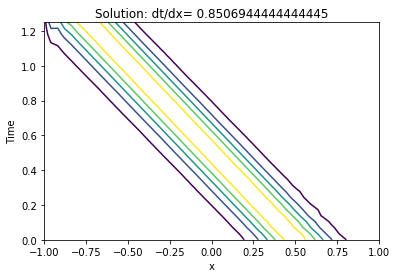

In [201]:
sol = leapfrog_wave1way_solve(x, t, ICs, c)
arraycontourplot(t, x, sol, labels=['x','Time'], levels=[0.1,0.3,0.5, 0.7,0.9], titlestring="Solution: dt/dx= "+str(dt/dx))

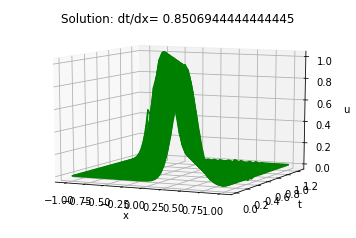

In [202]:
fig = plt.figure()
ax = plt.axes(projection="3d")

X, Y = np.meshgrid(x, t)
Z = np.clip(sol,-2,2)

ax.plot_wireframe(X, Y, Z, color='green')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.view_init(10,-65) #elevation and azimuth (rotation around z-axis) for viewing
ax.set_title("Solution: dt/dx= "+str(dt/dx))
plt.show()

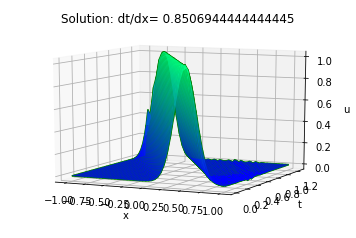

In [203]:
fig = plt.figure()
ax = plt.axes(projection="3d")

X, Y = np.meshgrid(x, t)
Z = Z = np.clip(sol,-2,2) 

ax.plot_wireframe(X, Y, Z, color='green')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_title("Solution: dt/dx= "+str(dt/dx));
ax.view_init(10,-65) #elevation and azimuth (rotation around z-axis) for viewing
plt.show()

Again things look reasonable (with values propagating nicely along characteristic lines).

What happens when we attempt larger time steps?

In [204]:
#initialization including wave speed
c = 1.
xmin, xmax, nx = -1, 1, 50
x = np.linspace(xmin, xmax,nx) #compute the coordinates of the grid points
dx = (xmax-xmin)/(nx-1) #spacing between grid points
tmin, tmax, nt = 0, 1.25, 29
t = np.linspace(tmin, tmax, nt) #compute the discrete time values
dt = (tmax-tmin)/(nt-1) #time step
u = np.zeros([nt,nx]) #initialize array of zeros to store u(x,t)
ICs = np.exp(-((x-0.5)/0.2)**2) #Gaussian initial conditions
u[0] = ICs

In [205]:
print("dx = ", dx)
print("dt = ", dt)
print("dt/dx = ", dt/dx)

dx =  0.04081632653061224
dt =  0.044642857142857144
dt/dx =  1.0937500000000002


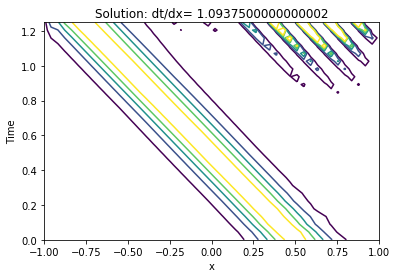

In [206]:
sol = leapfrog_wave1way_solve(x, t, ICs, c)
arraycontourplot(t, x, sol, labels=['x','Time'], levels=[0.1,0.3,0.5, 0.7,0.9], titlestring="Solution: dt/dx= "+str(dt/dx))

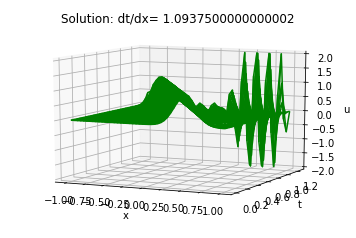

In [207]:
fig = plt.figure()
ax = plt.axes(projection="3d")

X, Y = np.meshgrid(x, t)
Z = np.clip(sol,-2,2)

ax.plot_wireframe(X, Y, Z, color='green')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.view_init(10,-65) #elevation and azimuth (rotation around z-axis) for viewing
ax.set_title("Solution: dt/dx= "+str(dt/dx))
plt.show()

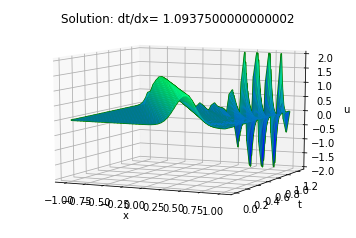

In [208]:
fig = plt.figure()
ax = plt.axes(projection="3d")

X, Y = np.meshgrid(x, t)
Z = Z = np.clip(sol,-2,2) 

ax.plot_wireframe(X, Y, Z, color='green')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_title("Solution: dt/dx= "+str(dt/dx));
ax.view_init(10,-65) #elevation and azimuth (rotation around z-axis) for viewing
plt.show()

Once again, errors creep in and instability arises when the time step is too large.

The resulting behavior is very different for $\Delta t/\Delta x \approx 0.85$ and $\Delta t/\Delta x \approx 1.1$.

To understand what is going on, we need to consider the stability issue in more detail.

## Section 9.3 - Stability Analysis

The basics of _von Neumann Stability Analysis_ is presented starting on p. 210. Here will follow along with a slightly different presentation of related ideas. Let's start by restricting to linear PDEs, and consider the numerical solution as a small perturbation from the exact solution: 

$$u = u_{exact} + \epsilon v$$

Substituting into the PDE gives:

$$\frac{\partial u_{exact}}{\partial t} + \frac{\partial v}{\partial t} = c \frac{\partial u_{exact}}{\partial x} + c \frac{\partial v}{\partial x}$$

Since $u_{exact}$ satisfies the PDE, those terms cancel out leaving:

$$\frac{\partial v}{\partial t} = c \frac{\partial v}{\partial x}$$

The bottom line is that, for linear equations, the error evolves as follows:

- Error satisfies the same PDE satisfied by the exact solution.

- Error satisfies the same discrete update formula (since that is the discrete version of the PDE).

The von Neumann approach is to seek solutions to the PDE (now describing the evolving error) of the type you would get from separation of variables consisting of the product of 2 terms:

- A general exponential solution, $e^{\alpha t}$ that discretizes to a geometric function: 
$$e^{\alpha t} = e^{\alpha k \Delta t} = (e^{\alpha \Delta t})^k = g^k$$

- A Fourier series (or a term from a Fourier series) in $x$ (appropriate for a periodic extension of the finite domain).

Thinking back to our discussion of the discrete Fourier Transform, a discrete grid of $n$ points allows us to compute $n$ components in terms of spatial frequency or __wavenumber (radians per unit length)__. The fundamental wavenumber (corresponding to one cycle over the sample domain) is $k_0 = 2 \pi/(N \Delta x)$, so the discrete wavenumbers of interest are:

$$k_n = n k_0 = n \frac{2 \pi}{N \Delta x}$$



We can now write the full expression for the assumed form of the discretized solution:

$$u(x_j, t_m) = u(j \Delta x, m \Delta t) = u_j^{(m)} = g^m exp(i k_n \cdot (j\Delta x)) \text{ where } k_n = n \frac{2 \pi}{N \Delta x}$$

Note that the spatial index has been changed to $j$ to avoid confusion with $i = \sqrt{-1}$ (apologies to those with an electrical engineering background would make the other choice), and the time index has been changed to $m$ to avoid confusion with the wavenumber.

We now plug the assumed form of the solution into the difference equation. For explicit Euler in time with central difference in space, the discretized equation is:

$$u_j^{(m+1)} = u_j^{(m)} + \frac{\lambda}{2}\big[u_{j+1}^{(m)}-u_{j-1}^{(m)}\big] \text{ where } \lambda=\frac{c \Delta t}{\Delta x}$$

and substituting the assumed form gives:

$$g^{m+1} exp(i k_n j \Delta x) = g^{m} exp(i k_n j \Delta x) +\frac{\lambda}{2} \big[g^{m} exp(i k_n (j+1) \Delta x)-g^{m} exp(i k_n (j-1) \Delta x)\big] $$

Note the effects of incrementing the indices:

- $m \rightarrow m+1$ introduces a factor of $g$

- $j \rightarrow j \pm 1$ introduces a factor of $exp(\pm i k_n \Delta x)$ in the square bracketed term.

Dividing through by $g^{m} exp(i k_n j \Delta x)$ gives:

\begin{equation}
\begin{split}
g &= 1 +\frac{\lambda}{2} \big[exp(i k_n (j+1-j) \Delta x)-exp(i k_n (j-1-j) \Delta x)\big] \\
  &= 1 +\frac{\lambda}{2} \big[exp(i k_n \Delta x)- exp(-i k_n \Delta x)\big] \\
  &= 1 +\frac{\lambda}{2}\frac{2i}{2i} \big[exp(i k_n \Delta x)- exp(-i k_n \Delta x)\big] \\
  &= 1 +i \lambda \big[\frac{exp(i k_n \Delta x)- exp(-i k_n \Delta x)}{2i}\big] \\
  &= 1 +i \lambda sin(k_n \Delta x) \\
  &= 1 +i \lambda sin(n \frac{2 \pi}{N \Delta x} \Delta x) \\
  &= 1 +i \lambda sin(2 \pi \frac{n}{N})
\end{split}
\end{equation}

What we really need is the magnitude of $g$:

\begin{equation}
\begin{split}
\big| g \big| &= \sqrt{g^* g} \\
&= \sqrt{(1 +i \lambda sin(2 \pi \frac{n}{N})(1 -i \lambda sin(2 \pi \frac{n}{N})} \\
&= \sqrt{1+\lambda^2 sin^2(2 \pi \frac{n}{N})} \geq 1
\end{split}
\end{equation}

The magnitude of the multiplier is (in general) greater than one, so errors grow with each time step.

__Time stepping with explicit Euler method is UNSTABLE FOR ALL STEPSIZES for the one-way wave equation.__

$\implies$ Time stepping with explicit Euler worked for the heat equation (if the time step is small enough), but it is NOT a suitable method to apply to this PDE, and we need to consider other approaches to find a suitable method.



__Time stepping with Implicit Euler__

For implicit Euler in time with central difference in space, the discretized equation is:

$$u_j^{(m+1)} = u_j^{(m)} + \frac{\lambda}{2}\big[u_{j+1}^{(m+1)}-u_{j-1}^{(m+1)}\big] \text{ where } \lambda=\frac{\Delta t}{\Delta x}$$

(The only change needed from the explicit version is changing the step number from $(m) \text{ to } (m+1)$ in the term multiplying $\lambda$.)

We now plug in the assumed form of the solution and do a similar bit of algebra:

$$g^{m+1} exp(i k_n j \Delta x) = g^{m} exp(i k_n j \Delta x) +\frac{\lambda}{2} \big[g^{m+1} exp(i k_n (j+1) \Delta x)-g^{m+1} exp(i k_n (j-1) \Delta x)\big] $$

Dividing through by $g^{m} exp(i k_n j \Delta x)$ and simplifying gives:

\begin{equation}
\begin{split}
g &= 1 + g\frac{\lambda}{2} \big[exp(i k_n (j+1-j) \Delta x)-exp(i k_n (j-1-j) \Delta x)\big] \\
  &= 1 + g\frac{\lambda}{2} \big[exp(i k_n \Delta x)- exp(-i k_n \Delta x)\big] \\
  &= 1 + g\frac{\lambda}{2}\frac{2i}{2i} \big[exp(i k_n \Delta x)-g^{m} exp(-i k_n \Delta x)\big] \\
  &= 1 +i g\lambda \big[\frac{exp(i k_n \Delta x)- exp(-i k_n \Delta x)}{2i}\big] \\
  &= 1 +i g\lambda sin(k_n \Delta x) \\
  &= 1 +i g\lambda sin(n \frac{2 \pi}{N \Delta x} \Delta x) \\
  &= 1 +i g\lambda sin(2 \pi \frac{n}{N})
\end{split}
\end{equation}

The final expression for $g$ is:

$$g = \frac{1}{1-i\lambda sin(2 \pi \frac{n}{N})}$$

and the magnitude of $g$ is:

\begin{equation}
\begin{split}
\big| g \big| &= \sqrt{g^* g} \\
&= \sqrt{\frac{1}{(1 -i \lambda sin(2 \pi \frac{n}{N})(1 +i \lambda sin(2 \pi \frac{n}{N})}} \\
&= \sqrt{\frac{1}{1+\lambda^2 sin^2(2 \pi \frac{n}{N})}} \leq 1
\end{split}
\end{equation}

The magnitude of the multiplier is never greater than one, so errors do not grow with each time step. 

__Time stepping with implict Euler method is UNCONDITIONALLY STABLE for the one-way wave equation.__

$\implies$ Time stepping with explicit Euler is a suitable method to apply to this PDE, but stability is gained at the cost of having to solve a linear system (instead of doing a matrix-vector multiplication) at each time step.

Is there some middle ground? Are there methods that provide stability without the cost of a linear solve at each time step?

## Leap-frog (2,2) for one-way wave equation

The analysis for the leap-frog method is similar. The "(2,2)" designation means that 2 spatial neighbors and 2 temporal neighbors are involved in the basic stencil for the first central difference. An alternative terminology would be to say that __the stencil has radius 1__.

The discretized equation needs only a minor changes from the explicit Euler update formula: the time index on the right-had side is adjusted from $(m) \text{ to } (m-1)$ and the factor of 2 cancels ($\frac{2 \Delta t}{2\Delta x}=\frac{\Delta t}{\Delta x}=\lambda$) yielding:

$$u_j^{(m+1)} = u_j^{(m-1)} + \lambda \big[u_{j+1}^{(m)}-u_{j-1}^{(m)}\big] $$

and substituting the assumed form gives:

$$g^{m+1} exp(i k_n j \Delta x) = g^{m-1} exp(i k_n j \Delta x) +\lambda \big[g^{m} exp(i k_n (j+1) \Delta x)-g^{m} exp(i k_n (j-1) \Delta x)\big] $$

Dividing through by $g^{m-1} exp(i k_n j \Delta x)$ gives:

\begin{equation}
\begin{split}
g^2 &= 1 +\lambda g \big[exp(i k_n (j+1-j) \Delta x)-exp(i k_n (j-1-j) \Delta x)\big] \\
  &= 1 +\lambda g \big[exp(i k_n \Delta x)- exp(-i k_n \Delta x)\big] \\
  &= 1 +\lambda g \frac{2i}{2i} \big[exp(i k_n \Delta x)- exp(-i k_n \Delta x)\big] \\
  &= 1 +i 2\lambda g \big[\frac{exp(i k_n \Delta x)- exp(-i k_n \Delta x)}{2i}\big] \\
  &= 1 +i 2\lambda g sin(k_n \Delta x) \\
  &= 1 +i 2\lambda g sin(n \frac{2 \pi}{N \Delta x} \Delta x) \\
  &= 1 +i 2 \lambda g sin(2 \pi \frac{n}{N})
\end{split}
\end{equation}

So $g$ satisfies:

$$g^2 - i 2 \lambda sin(2 \pi \frac{n}{N}) g -1 = 0 $$

What we really need to ensure is that the magnitude of $g$ does not exceed 1, so let's rewrite as:

$$g^2 + 2 b g + c =0 \text{ where } b=-i \lambda sin(2 \pi \frac{n}{N}); \; c=-1$$

and compare with the factored version with roots $g_1, g_2$:

$$(g-g_1)(g-g_2) = g^2 - (g_1 + g_2) g +g_1 g_2$$

The product of the roots must have magnitude $|c|=1$, so the roots are either complex conjugates lying on the unit circle or real with magnitudes that multiply to 1. The real root case implies that one root has magnitude $>1$ which implies instability, so we need to apply the condition assuring complex roots:

$$b^2 - c<0 \implies |b|<1 \implies \lambda^2 sin^2(2 \pi \frac{n}{N}) <1 \implies \lambda<1$$

So this leap-frog scheme is a candidate for practical use to solve the one-way wave equation, but with a restriction:

__The time step must be chosen to be smaller than the grid spacing.__

It is typical that the stability limit for problems with wave propagation (advection) involves a bound on the speed at which information can propagate in the system that depends on the stepsizes. 

The dimensionless ratio $\frac{c \Delta t}{\Delta x}$ is referred to as the __Cauchy number__.

(Here we have $c=1$, so $\lambda$ is the Cauchy number in the analysis of the one-way wave equation above.) 

The condition that the Cauchy number must be less than some upper bound is referred to as the __CFL condition__ after Courant, Friedrichs, and Lewy who introduced it in a 1928 paper.

## Upwind differencing

So far, we have focused on the necessity of limiting the size of the time step to maintain stability. Before we leave the one-way wave equation, $u_t = c u_x$, let's take a close look at the influence of the spatial differencing scheme.

Here we stick with basic forward Euler differencing to approximate the time derivative and consider three possiblities for the spatial differencing:

- __Upwind:__ waves are propagating from right to left, so the upwind direction is to the right:

$$\frac{u_j^{(m+1)}-u_j^{(m)}}{\Delta t} = c \frac{u_{j+1}^{(m)}-u_j^{(m)}}{\Delta x}$$

Applying stability analysis gives:

$$\frac{g-1}{\Delta t} = c \frac{exp(i k_n \Delta x)-1}{\Delta x}$$

$$g = 1-r+r e^{i k_n \Delta x} ; \qquad r = \frac{c \Delta t}{\Delta x}$$

$$\big|g \big| \leq \big|1-r\big|+r \big|e^{i k_n \Delta x}\big| = 1 \implies 0 \leq r \leq 1 $$

$$\implies \boldsymbol{ CONDITIONAL \; STABILITY } \text{ and requires } 0 \leq c \Delta t/\Delta x \leq 1$$

- __Downwind:__ waves are propagating from right to left, so the downwind direction is to the left:

$$\frac{u_j^{(m+1)}-u_j^{(m)}}{\Delta t} = c \frac{u_{j}^{(m)}-u_{j-1}^{(m)}}{\Delta x}$$

Applying stability analysis gives:

$$\frac{g-1}{\Delta t} = c \frac{1-exp(-i k_n \Delta x)}{\Delta x}$$

$$g = 1+r-r e^{i k_n x} = 1+r(1-e^{i k_n x})$$

The term multiplying $r$ generally has positive magnitude, so $\big|g \big| > 1 \implies \boldsymbol{ UNSTABLE }$

- __Central:__

$$\frac{u_j^{(m+1)}-u_j^{(m)}}{\Delta t} = c \frac{u_{j+1}^{(m)}-u_{j-1}^{(m)}}{2 \Delta x}$$

Applying stability analysis gives:

$$\frac{g-1}{\Delta t} = c \frac{exp(i k_n \Delta x)-exp(-i k_n \Delta x)}{2 \Delta x}$$

$$g = 1+ i r \frac{e^{i k_n \Delta x} -e^{-i k_n \Delta x}}{2i} = 1+ i r sin(k_n \Delta x)$$

$$\big|g \big| =\sqrt{1+r^2 sin^2(k_n \Delta x)} > 1 \implies \boldsymbol{ UNSTABLE }$$

Take-away points:

- __Upwind differencing is conditionally stable:__ suitable for sufficiently small time step.

- __Downwind fails due to instability. ___To propagate information reliably , need to sample where the information is coming from.___

- __Central differencing fails due to instability, but can be saved.__ It is close enough to enable an adjustment (adding a bit of diffusion) that makes it practical.


### Lax Wendroff for one-way wave equation

This approach is a bit more sophisticated; it starts with the simple forward Euler update

$$\frac{u_j^{(m+1)} - u_j^{(m)}}{\Delta t} = c \frac{u_{j+1}^{(m)}-u_{j-1}^{(m)}}{2 \Delta x}$$

and adds a small diffusion term (aiming for diffusion to damp out instability):

$$\frac{u_j^{(m+1)} - u_j^{(m)}}{\Delta t} = c \frac{u_{j+1}^{(m)}-u_{j-1}^{(m)}}{2 \Delta x} + \epsilon \frac{u_{j+1}^{(m)}-2 u_{j}^{(m)} +u_{j-1}^{(m)}}{\Delta x^2}$$

How much diffusion should be added? Is this still a discretization of the one-way wave equation?

To answer such questions, go back to the Taylor series:

\begin{equation}
\begin{split}
u&(x &,t&) &= u \\
u&(x &,t+\Delta t&) &= u + u_t \Delta t + (1/2) u_{tt} \Delta t^2 + (1/6)u_{ttt} \Delta t^3 + \ldots\\
u&(x+\Delta x &,t&) &= u + u_x \Delta x + (1/2) u_{xx} \Delta x^2 + (1/6)u_{xxx} \Delta x^3 + \ldots\\
u&(x-\Delta x &,t&) &= u - u_x \Delta x + (1/2) u_{xx} \Delta x^2 - (1/6)u_{xxx} \Delta x^3 + \ldots
\end{split}
\end{equation}


Interpreting $u_j^{(m+1)}$ as $u(x,t+\Delta t)$ and $u_{j\pm 1}^{(m)}$ as $u(x \pm \Delta x,t)$,
plug the Taylor series into the difference equation to get:

$$u_t+(1/2)u_{tt} \Delta t +(1/6) u_{ttt} \Delta t^2 + \ldots = c u_x + (c/6) u_{xxx} \Delta x^2 +\ldots + \epsilon u_{xx} \Delta x +\ldots$$

The leading terms on each side make up the one-way wave equation, $u_t = c u_x$, so we can cancel those out and also differentiate again with respect to $t$ to get: 

$$u_{tt}=(u_t)_t = (c u_x)_t = c u_{xt} = c u_{tx} = c (u_t)_x =c (c u_x)_x = c^2 u_{xx}$$

Substituting in for $u_{tt}$ on the left-hand side, we can get the second term on the left to cancel with the last term on the right by choosing:

$$\epsilon = \frac{c^2}{2}\Delta t$$

which leaves:

$$u_t +O(\Delta t^2) = c u_x + O(\Delta x^2)$$

and we see that the Lax-Wendroff scheme does in fact discretize the one-way wave equation with second order error in both $\Delta x$ and $\Delta t$. 

Now let's consider its stability. Substituting the usual form of the solution, $u = g^m exp(i k_n (j \Delta x))$, into the difference equation:

$$\frac{u_j^{(m+1)} - u_j^{(m)}}{\Delta t} = c \frac{u_{j+1}^{(m)}-u_{j-1}^{(m)}}{2 \Delta x} + \frac{c^2 \Delta t^2}{\Delta x^2} \frac{u_{j+1}^{(m)}-2 u_{j}^{(m)} +u_{j-1}^{(m)}}{\Delta x^2}$$

 and dividing through by $g^m exp(i k_n (j \Delta x))$ gives:

$$g-1= \frac{c \Delta t}{\Delta x} \big[ \frac{exp(i k_n \Delta x)-exp(-i k_n \Delta x)}{2} \big]+
\frac{c^2 \Delta t^2}{\Delta x^2} \big[ \frac{exp(i k_n \Delta x)-2 +exp(-i k_n \Delta x)}{2} \big]$$

$$g = 1-r^2+r^2 cos(k_n \Delta x) +i \,r \, sin(k_n \Delta x) \text{ with Courant number } r=\frac{c \Delta t}{\Delta x}$$

Again, we care about the magnitude of the amplification factor and whether $\big| g \big| \leq 1$:

\begin{equation}
\begin{split}
\big| g \big| &= \big[1-r^2 +r^2 cos(k_n \Delta x)\big]^2 + r^2 sin^2(k_n \Delta x)\\
 &= \big[1-r^2 +r^2 cos(k_n \Delta x)\big]^2 + r^2 (1-cos^2(k_n \Delta x))
\end{split}
\end{equation}

This expression depends on the wavenumber through $cos(k_n \Delta x)$ so, for any value of the Courant number $r$, the extreme values will occur in association with extrema of $cos(k_n \Delta x)$; i.e. $cos(k_n \Delta x) = \pm 1$. In both cases, the second term vanishes, so we can focus on the term in the square bracket.

When $cos(k_n \Delta x) = 1$, the expression simplifies to  $\big| g \big|=1 \leq 1$.

When $cos(k_n \Delta x) = -1$, the expression simplifies  to $\big| g \big|=\big| 1-2 r^2 \big| \leq 1 \implies 0 \leq r \leq 1$.

The bottom line is that the Lax-Wendroff avoids numerical instability subject to the CFL condition:

$$0 < r = \frac{c \Delta t}{\Delta x} \leq 1$$

Some comments on stability analysis are worth noting at this point:

- It is a general result that simple difference schemes (not something like Runge-Kutta) that are foward in time and centered in space are unstable for the one-way wave equation.

- von Neumann analysis does not guarantee stability; it is __necessary but not sufficient__.

- There are other mechanisms not captured by the von Neumann approach that can cause unstable growth.

- von Neumann analysis is focused on linear PDEs; nonlinearity requires more powerful (and usually more complicated) approaches.

- We have discussed both accuracy and stability. Which should you focus on? Typically, __focus on accuracy__. The results of an unstable method will blow up and become obviously wrong. An inaccurate scheme can produce a solution with significant error without providing an obvious indication that something has gone wrong.

## Section 9.4 - Comparison of Time-Stepping Schemes

Above we predicted that the basic (2,2) leap-frog scheme is conditionally stable for the one-way wave equation. We just need to ensure that we satisfy the CFL condition $c \frac{\Delta t}{\Delta x} \leq 1$. To double the accuracy of the solution, both $\Delta x \text{ and } \Delta t$ need to be cut in half.

We looked at this and several other approaches to solving the one-way wave equation. Now let's see if the results apply across different PDEs and consider applying the leap-frog method to the heat (diffusion) equation that we have solved previously by other methods:

$$\frac{\partial u}{\partial t} = c \frac{\partial^2 u}{\partial t^2}$$

Applying the leap-frog discretization scheme leads to the following difference equation:

$$\frac{u^{(m+1)}_j -u^{(m-1)}_j}{2 \Delta t} = c \frac{u^{(m)}_{j+1}-2 u^{(m)}_{j} + u^{(m)}_{j-1}}{\Delta x^2}$$

Multiplying through by $\Delta t$ and introducing the Courant number $\lambda = \frac{c \Delta t}{\Delta x}$, gives:

$$u^{(m+1)}_j -u^{(m-1)}_j = 2 \lambda (u^{(m)}_{j+1}-2 u^{(m)}_{j} + u^{(m)}_{j-1})$$

Once again, we employ the von Neumann ansatz $ u^{(m)}_j = g^{m} exp(i k_n j \Delta x)$ and divide through by $g^{m-1} exp(i k_n j \Delta x)$ to obtain:

$$g^2 + 2 b g -1 = 0 \text{ where } b = \lambda (i sin(k_n \Delta x) -1)$$

Similar to our previous encounter with a quadratic equation of this form, the roots will lie onthe unit circle (and not produce instability) if the discriminant $b^2 + 1$ is negative. However,

$$b^2 +1 = 1+\lambda^2 (1- sin(k_n \Delta x))^2$$

Which is non-negative, so the amplification factor is greater than 1. We have previously seen:

- The leap-frog scheme was conditionally stable for the one-way wave equation.

And we can now conclude:

- The leap-frog scheme is UNSTABLE regardless of stepsize for the heat equation.

MORAL OF THE STORY: __You need to pick a scheme that is appropriate for the particular class of PDE you want to solve.__

A COMMENT ON HYPER-DIFFUSION: Higher derivatives lead to higher powers of the stepsize and more stringent stepsize restrictions. A central difference operator for a 4th spatial derivative will have a factor of $\Delta x^{-4}$ leading to a Courant number $\lambda = \frac{c \Delta t}{\Delta x^4}$. Satisfying a condition like $\lambda < const.$ will require very small time steps.

## Section 9.5 Operator Splitting Techniques

Through some experimentation along with von Neumann stability analysis of some representative problems, we can now identify methods appropriate for certain classes of problems:

- Wave behavior (advection): $u_t =c u_x$

    - Forward Euler: unstable for all stepsizes
    
    - leap-frog (2,2): conditionally stable for $\lambda = \frac{c \Delta t}{\Delta x} \leq 1$

- Diffusive behavior: $u_t = u_{xx}$

    - forward Euler: conditionally stable for $\frac{|delta t}{\Delta x^2} \leq \frac{1}{2}$
    
    - leap-frog (2,2): unstable for all stepsizes
    
Now we face the reality that not all PDEs fall neatly into our classifications. What do you do when you encounter a PDE that includes multiple kinds of behavior? For example, consider the following advection-diffusion equation that includes both a wave-like term and a diffusive term:

$$\frac{\partial u}{\partial t} = \frac{\partial u}{\partial x} + \frac{\partial^2 u}{\partial x^2}$$

While each of the methods listed above would be driven to instability by one of the terms in the PDE, we can actually combine the two methods to create an effective approach.

### Operator splitting

The basic idea here is straightforward: decouple the terms that produce very different mathematical behavior (modeling very different physical effects) by assuming that over suitably small time steps wave propagation is approximately independent of diffusion and vice versa.

Following this approach, we split the equation above into two pieces, the one-way wave equation and the heat equation, each of which allows a useful (conditionally stable) update scheme (leap-frog and forward Euler respectively).

The computation proceeds by alternating between the two updates. 

- Starting with current values $u^{(m)}$, perform forward Euler update of the one-way wave equation with stepsize $\Delta t$ to compute $v^{(m)}$.

- Leap-frog update of heat equation with stepsize $\Delta t$ using $v^{(m)}$ as current values to compute $u^{(m+1)}$.


There are a variety of ways to do this, but one deserves special mention: the Strang symmetric splitting technique where one of the updates is split into half steps with the other update performed in between. For the example equation above, each full update step involves 3 sub-steps:

- Forward Euler update  of the one-way wave equation with stepsize $(1/2) \Delta t$ to obtain $v_0^{(m)}$.

- Treating $v_0^{(m)}$ as current state, leap-frog update of heat equation with stepsize $\Delta t$ to obtain $v_1^{(m)}$.

- Treating $v_1^{(m)}$ as current state, forward Euler update of the one-way wave equation with stepsize $(1/2) \Delta t$ to obtain $u^{(m+1)}$.

You should read the rest of Ch. 9 and compare the plots from your homework with the results presented in Section 9.6.